**<파일 경로>**
- C:/Users/Brian/Desktop/Data Science/Projects/Playdata/dataset/made_by_전처리/train
- C:/Users/Brian/Desktop/Data Science/Projects/Playdata/dataset/made_by_전처리/test

In [1]:
train_path = input()

C:/Users/Brian/Desktop/Data Science/Projects/Playdata/dataset/made_by_전처리/train


In [2]:
test_path = input()

C:/Users/Brian/Desktop/Data Science/Projects/Playdata/dataset/made_by_전처리/test


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# seaborn 폰트 및 스타일 설정
sns.set(font = "Malgun Gothic", rc = {"axes.unicode_minus": False}, style = 'whitegrid')
# Pandas 출력 결과 부동소수점 설정
pd.options.display.float_format = '{:.1f}'.format

from sklearn.model_selection import KFold, cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from bayes_opt import BayesianOptimization

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

- 먼저 메모리 절약을 위해 각 변수들의 데이터 타입을 지정해 준 뒤, 각 데이터 셋을 불러오도록 하겠다.

In [4]:
df_train_dtype = {
    # 지하철 데이터 관련 변수들 데이터 타입 지정
    'boarding_num': np.int32, 'log_boarding_num': np.float32, 'platform_area': np.float32, 
    'length': np.float32, 'transfer_num': np.float32, 'entrance': np.float32, 
    'msi_cnt': np.float32, 'hsi_cnt': np.float32, 'uvi_cnt': np.float32, 
    'hpi_cnt': np.float32, 'mti_cnt': np.float32, 'day': np.int32,
    # 인구 데이터 관련 변수들 데이터 타입 지정
    'pop_below_20': np.float32, 'pop_20_30_40': np.float32, 'pop_over_50': np.float32,
    # 기상 데이터 관련 변수들 데이터 타입 변경
    'temp': np.float32, 'windspeed': np.float32, 'rain': np.float32
}

df_test_dtype = {
    # 지하철 데이터 관련 변수들 데이터 타입 지정
    'boarding_num': np.int32, 'platform_area': np.float32, 
    'length': np.float32, 'transfer_num': np.float32, 'entrance': np.float32, 
    'msi_cnt': np.float32, 'hsi_cnt': np.float32, 'uvi_cnt': np.float32, 
    'hpi_cnt': np.float32, 'mti_cnt': np.float32, 'day': np.int32,
    # 인구 데이터 관련 변수들 데이터 타입 지정
    'pop_below_20': np.float32, 'pop_20_30_40': np.float32, 'pop_over_50': np.float32,
    # 기상 데이터 관련 변수들 데이터 타입 변경
    'temp': np.float32, 'windspeed': np.float32, 'rain': np.float32
}

In [5]:
df_train = pd.read_csv('{}/df_train_nonlinear_line2.csv'.format(train_path), dtype = df_train_dtype)
df_test = pd.read_csv('{}/df_test_nonlinear_line2.csv'.format(test_path), dtype = df_test_dtype)

- 추가적인 메모리 절약을 위해 line과 station_name 변수의 타입을 category로 변환하고, 원-핫 인코딩 처리된 변수들의 dtype을 모두 uint8로 지정해주겠다.

In [6]:
cat_vars = ['line', 'station_name']

for var in tqdm(cat_vars):
    df_train[var] = df_train[var].astype('category')
    df_test[var] = df_test[var].astype('category')

In [7]:
# One-Hot Encoding 처리된 변수들의 데이터 타입 변경
df_train[df_train.columns[21:]] = df_train.iloc[:, 21:].astype('uint8')
df_test[df_test.columns[20:]] = df_test.iloc[:, 20:].astype('uint8')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460000 entries, 0 to 1459999
Columns: 120 entries, date to season_winter
dtypes: category(2), float32(16), int32(2), object(1), uint8(99)
memory usage: 252.0+ MB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364000 entries, 0 to 363999
Columns: 119 entries, date to season_winter
dtypes: category(2), float32(15), int32(2), object(1), uint8(99)
memory usage: 61.4+ MB


# Modeling

## 평가 지표
- 이번 분석에서는 RMSE를 평가 지표로 사용할 것이다.
- 따라서 RMSE를 계산해주는 함수를 하나 만들도록 하겠다.

<참고>
- 이와 더불어 R2 score 또한 서브 평가 지표로써 사용하도록 하겠다.

In [10]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

## 변수 선택 및 데이터 분할

### Feature dataset / Target dataset 생성
- 먼저 train dataset과 test dataset에서 모델에 넣지 않을 불필요한 변수들은 제거해주겠다.
    - train dataset
        - 'date', 'line', 'station_name', 'boarding_num', 'log_boarding_num', 'day'
    - test dataset
        - 'date', 'line', 'station_name', 'boarding_num', 'day'
        
<참고>
- 앞서 선형 모델에서는 다중공선성 문제로 인해 pop_over_50(50세 이상 인구 수) 변수를 제외했을 때의 예측 성능이 더 높게 나왔다.
- 그러나 트기 기반 모델의 경우, pop_over_50(50세 이상 인구 수) 변수를 제외했을 때의 예측 성능이 더 낮게 나왔다.
    - 이러한 결과가 나온 이유는 트리 기반 모델의 경우, 다중공선성 문제로 인한 영향을 크게 받지 않기 때문이다.
    - 따라서 pop_over_50(50세 이상 인구 수) 변수를 모델에 포함시키겠다.

In [11]:
df_train.columns.tolist()

['date',
 'line',
 'station_name',
 'boarding_num',
 'platform_area',
 'length',
 'transfer_num',
 'entrance',
 'msi_cnt',
 'hsi_cnt',
 'uvi_cnt',
 'hpi_cnt',
 'mti_cnt',
 'temp',
 'windspeed',
 'rain',
 'pop_below_20',
 'day',
 'pop_20_30_40',
 'pop_over_50',
 'log_boarding_num',
 'boarding_승차',
 'boarding_하차',
 'gu_강남구',
 'gu_강동구',
 'gu_강북구',
 'gu_강서구',
 'gu_관악구',
 'gu_광진구',
 'gu_구로구',
 'gu_금천구',
 'gu_노원구',
 'gu_도봉구',
 'gu_동대문구',
 'gu_동작구',
 'gu_마포구',
 'gu_서대문구',
 'gu_서초구',
 'gu_성동구',
 'gu_성북구',
 'gu_송파구',
 'gu_양천구',
 'gu_영등포구',
 'gu_용산구',
 'gu_은평구',
 'gu_종로구',
 'gu_중구',
 'gu_중랑구',
 'type_복합식',
 'type_상대식',
 'type_섬식',
 'floor_1F',
 'floor_1FB2',
 'floor_1FB3',
 'floor_1FB5',
 'floor_2F',
 'floor_2FB2',
 'floor_2FB3',
 'floor_3F',
 'floor_4F',
 'floor_5FB2',
 'floor_B1',
 'floor_B2',
 'floor_B3',
 'floor_B4',
 'floor_B5',
 'floor_B6',
 'floor_B8',
 'year_2018',
 'year_2019',
 'year_2020',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',


In [12]:
# columns for drop in train dataset
drop_list1 = ['date', 'line', 'station_name', 'boarding_num', 
              'log_boarding_num', 'day']
# columns for drop in test dataset
drop_list2 = ['date', 'line', 'station_name', 
              'boarding_num', 'day']

# 학습 데이터 셋
X_features = df_train.drop(drop_list1, axis = 1, inplace = False)
y_target = df_train['boarding_num'] # 로그 변환되지 않은 타겟 변수
log_y_target = df_train['log_boarding_num'] # 로그 변환된 타겟 변수
print('학습 데이터 셋:', X_features.shape, y_target.shape, log_y_target.shape)

# 테스트 데이터 셋
X_test = df_test.drop(drop_list2, axis = 1, inplace = False)
y_test = df_test['boarding_num']
print('테스트 데이터 셋:', X_test.shape, y_test.shape)

학습 데이터 셋: (1460000, 114) (1460000,) (1460000,)
테스트 데이터 셋: (364000, 114) (364000,)


### 학습 데이터 셋 분할
- 전체 학습 데이터 셋을 다시 학습 데이터 셋과 검증 데이터 셋으로 분할해주겠다.

In [13]:
# 전체 학습 데이터 셋을 다시 학습 데이터 셋과 검증 데이터 셋으로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_features, y_target, 
                                                      test_size = 0.2, random_state = 1021)
print('학습 및 검증 데이터 셋:', X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

학습 및 검증 데이터 셋: (1168000, 114) (292000, 114) (1168000,) (292000,)


## Baseline Model
- 비선형 모델
    1. 결정 트리
    2. 랜덤포레스트
    3. XGBoost
    4. LightGBM

In [14]:
def baseline_nonlinear_model(model):
    # 모델 학습
    model.fit(X_train, y_train)
    # 예측
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    # RMSE 및 R2 Score 계산
    rmse_train = rmse(y_train, y_train_pred)
    r2_score_train = r2_score(y_train, y_train_pred)
    rmse_valid = rmse(y_valid, y_valid_pred)
    r2_score_valid = r2_score(y_valid, y_valid_pred)

    print('###', model.__class__.__name__, '###')
    print('학습 데이터 셋에 대한 RMSE: ', np.round(rmse_train, 4))
    print('학습 데이터 셋에 대한 R2 Score: ', np.round(r2_score_train, 4))
    print('검증 데이터 셋에 대한 RMSE: ', np.round(rmse_valid, 4))
    print('검증 데이터 셋에 대한 R2 Score: ', np.round(r2_score_valid, 4))
    print('-' * 50)

In [15]:
dt = DecisionTreeRegressor(random_state = 1021)
rf = RandomForestRegressor(n_jobs = -1, random_state = 1021)
xgb = XGBRegressor(random_state = 1021)
lgbm = LGBMRegressor(random_state = 1021)

nonlinear_models = [dt, rf, xgb, lgbm]

for model in tqdm(nonlinear_models):
    baseline_nonlinear_model(model)

### DecisionTreeRegressor ###
학습 데이터 셋에 대한 RMSE:  0.0
학습 데이터 셋에 대한 R2 Score:  1.0
검증 데이터 셋에 대한 RMSE:  323.9199
검증 데이터 셋에 대한 R2 Score:  0.9715
--------------------------------------------------
### RandomForestRegressor ###
학습 데이터 셋에 대한 RMSE:  89.0781
학습 데이터 셋에 대한 R2 Score:  0.9979
검증 데이터 셋에 대한 RMSE:  237.9877
검증 데이터 셋에 대한 R2 Score:  0.9846
--------------------------------------------------
### XGBRegressor ###
학습 데이터 셋에 대한 RMSE:  463.4016
학습 데이터 셋에 대한 R2 Score:  0.9419
검증 데이터 셋에 대한 RMSE:  469.8031
검증 데이터 셋에 대한 R2 Score:  0.9401
--------------------------------------------------
### LGBMRegressor ###
학습 데이터 셋에 대한 RMSE:  618.7132
학습 데이터 셋에 대한 R2 Score:  0.8964
검증 데이터 셋에 대한 RMSE:  617.5951
검증 데이터 셋에 대한 R2 Score:  0.8966
--------------------------------------------------



- Baseline Model들의 결과를 살펴보면, 확실히 선형 모델보다 성능이 훨씬 더 뛰어남을 알 수 있다.

## 하이퍼 파라미터 튜닝
- 베이스라인 모델들의 결과를 보면, 결정 트리와 랜덤포레스트 모델은 심하게 과대적합(overfitting)된 것을 알 수 있다.
- 따라서 과대적합이 되지 않은 부스팅 계열 모델(즉, XGBoost와 LightGBM 모델)에 대하여 하이퍼 파라미터 튜닝을 진행해주도록 하겠다.
    - 하이퍼 파라미터 튜닝 방법으로 BayesianOptimization(베이지안 최적화)을 사용하도록 하겠다.

### 하이퍼 파라미터 입력 범위 설정

In [16]:
# 1. XGBoost 모델 하이퍼 파라미터 입력 범위 설정
xgb_bayes_params = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (6, 12)
}
# 2. LightGBM 모델 하이퍼 파라미터 입력 범위 설정
lgbm_bayes_params = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (6, 12)
}

### 최댓값을 구할 함수 생성 (목적 함수)
- Iteration을 수행할 때마다, 하이퍼 파라미터를 입력받아 학습하고 **"-rmse"** 값을 반환하는 함수를 생성해주겠다.
    - 여기서 rmse 값을 음수로 반환하는 이유는 BayesianOptimization를 통해 가장 큰 target 값을 찾아줄 것이기 때문이다.
        - BayesianOptimization에 minimize()가 따로 존재하지 않아서, maximize()를 사용하기 위해 위와 같은 처리를 해 준 것이다.

In [17]:
# 1. XGBoost 모델의 최댓값을 구할 함수
def xgb_eval(learning_rate, max_depth, output = 'score'):
    params = {
        # n_estimators 값은 100으로 고정
        'n_estimators': 100,
        # 호출 시, 실수형 값들이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경해줘야 함
        'learning_rate': learning_rate,
        'max_depth': int(round(max_depth))
    }
    
    xgb = XGBRegressor(**params, random_state = 1021)
    
    # Cross Validation
    neg_mse_scores = cross_val_score(xgb, X_features, y_target,
                                     scoring = 'neg_mean_squared_error',
                                     cv = 3)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    mean_rmse = np.mean(rmse_scores)
    
    return -mean_rmse # BayesianOptimization의 maximize()를 사용하기 위해, RMSE 값을 음수로 반환

# 2. LightGBM 모델의 최댓값을 구할 함수
def lgbm_eval(learning_rate, max_depth, output = 'score'):
    params = {
        # n_estimators 값은 100으로 고정
        'n_estimators': 100,
        # 호출 시, 실수형 값들이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경해줘야 함
        'learning_rate': learning_rate,
        'max_depth': int(round(max_depth))
    }
    
    lgbm = LGBMRegressor(**params, random_state = 1021)
    
    # Cross Validation
    neg_mse_scores = cross_val_score(lgbm, X_features, y_target,
                                     scoring = 'neg_mean_squared_error',
                                     cv = 3)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    mean_rmse = np.mean(rmse_scores)
    
    return -mean_rmse # BayesianOptimization의 maximize()를 사용하기 위해, RMSE 값을 음수로 반환

### 베이지안 최적화
#### 함수 반환 값이 최대가 되는 입력 값을 찾기
- BayesianOptimization 객체 생성 후, 함수 반환 값이 최대가 되는 입력 값을 찾기 위해 iteration을 수행하겠다.
    - 원래는 RMSE 값이 클수록 모델의 예측 성능이 좋지 않다는 것을 의미하므로, 최댓값이 아닌 최솟값을 찾아주어야 한다.
    - 그런데 앞에서 최댓값을 구할 함수를 생성할 때, return 값을 **"rmse"**가 아닌 **"-rmse"**로 설정해주었기 때문에 최솟값이 아닌 최댓값을 찾아주는 것이 맞다.

#### 최대 target 값을 갖는 parameter 값 추출
- Iteration 결과 dictionary에서 최대 target 값을 갖는 index를 추출하고, 그때의 parameter 값을 추출하겠다.

In [18]:
def Bayesian_Opt(model_eval, model_bayes_params):
    # 베이지안 최적화
    model_bayes = BayesianOptimization(f = model_eval, pbounds = model_bayes_params, random_state = 1021)
    model_bayes.maximize(init_points = 5, n_iter = 25)
    
    print(model_bayes.res)
    print('\n')
    
    # dictionary에 있는 target 값을 모두 추출
    target_list = []
    for result in model_bayes.res:
        target = result['target']
        target_list.append(target)
    print(target_list)
    print('\n')

    # 가장 큰 target 값을 갖는 index를 추출
    print('Maximum target index of Model:', np.argmax(np.array(target_list)))
    print('\n')
    
    # 가장 큰 target 값을 갖는 index 값을 기준으로 res에서 해당 parameter를 추출
    max_dict = model_bayes.res[np.argmax(np.array(target_list))]
    print(max_dict)
    print('-' * 100)

In [19]:
# 1. XGBoost 모델 베이지안 최적화
Bayesian_Opt(xgb_eval, xgb_bayes_params)

|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
|  1        | -1.733e+0 |  0.1431   |  11.23    |
|  2        | -1.644e+0 |  0.1465   |  7.336    |
|  3        | -1.714e+0 |  0.1762   |  7.155    |
|  4        | -1.694e+0 |  0.1504   |  8.572    |
|  5        | -1.699e+0 |  0.04045  |  10.27    |
|  6        | -1.693e+0 |  0.1139   |  8.845    |
|  7        | -1.733e+0 |  0.1433   |  9.599    |
|  8        | -1.742e+0 |  0.1984   |  11.99    |
|  9        | -1.696e+0 |  0.04637  |  9.314    |
|  10       | -1.723e+0 |  0.06001  |  11.82    |
|  11       | -1.699e+0 |  0.02909  |  11.15    |
|  12       | -1.717e+0 |  0.02991  |  11.58    |
|  13       | -1.665e+0 |  0.06315  |  8.143    |
|  14       | -1.675e+0 |  0.04944  |  7.514    |
|  15       | -1.674e+0 |  0.03323  |  8.969    |
|  16       | -1.776e+0 |  0.1719   |  8.35     |
|  17       | -1.672e+0 |  0.1157   |  7.388    |
|  18       | -1.706e+0 |  0.2      |  7.356    |


In [20]:
# 2. LightGBM 모델 베이지안 최적화
Bayesian_Opt(lgbm_eval, lgbm_bayes_params)

|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
|  1        | -1.649e+0 |  0.1431   |  11.23    |
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
|  2        | -1.642e+0 |  0.1465   |  7.336    |
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_dep

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
|  22       | -1.65e+03 |  0.1067   |  7.146    |
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
|  23       | -1.635e+0 |  0.1406   |  7.495    |
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_d

## Prediction
- 최적 하이퍼 파라미터로 튜닝된 모델을 사용하여, 테스트 데이터 셋에 대한 최종 예측을 수행하겠다.

In [21]:
def best_model_pred(best_model):
    # 최종 예측 모델로 학습
    best_model.fit(X_train, y_train)
    
    # 테스트 데이터 셋에 대한 예측
    y_pred = best_model.predict(X_test)

    # 승/하차 인원 수는 소수가 나올 수 없으므로 int로 변경
    y_pred = y_pred.astype(int)
    
    # RMSE 및 R2 Score 계산
    RMSE = rmse(y_test, y_pred)
    R2_Score = r2_score(y_test, y_pred)

    print('###', best_model.__class__.__name__, '###')
    print('테스트 데이터 셋에 대한 RMSE: ', np.round(RMSE, 4))
    print('테스트 데이터 셋에 대한 R2 Score: ', np.round(R2_Score, 4))
    print('-' * 50)

In [22]:
# 1. The Best XGBoost Model
xgb_bayes_opt = XGBRegressor(n_estimators = 100, learning_rate = 0.1465,
                             max_depth = 7, random_state = 1021)
# 2. The Best LigthGBM Model
lgbm_bayes_opt = LGBMRegressor(n_estimators = 100, learning_rate = 0.2,
                               max_depth = 6, random_state = 1021)

In [23]:
best_models = [xgb_bayes_opt, lgbm_bayes_opt]

for model in tqdm(best_models):
    best_model_pred(model)

### XGBRegressor ###
테스트 데이터 셋에 대한 RMSE:  672.9618
테스트 데이터 셋에 대한 R2 Score:  0.8184
--------------------------------------------------
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
### LGBMRegressor ###
테스트 데이터 셋에 대한 RMSE:  704.5382
테스트 데이터 셋에 대한 R2 Score:  0.8009
--------------------------------------------------



- 이제 최종 예측된 값들을 테스트 데이터 셋에 새로운 컬럼으로 추가해주겠다.

In [24]:
# 테스트 데이터 셋에 대한 예측
xgb_pred = xgb_bayes_opt.predict(X_test)
lgbm_pred = lgbm_bayes_opt.predict(X_test)

# 승/하차 인원 수는 소수가 나올 수 없으므로 int로 변경
xgb_pred = xgb_pred.astype(int)
lgbm_pred = lgbm_pred.astype(int)

# 모델별 최종 예측 값들을 새로운 컬럼으로 추가
df_test['xgb_pred'] = xgb_pred
df_test['lgbm_pred'] = lgbm_pred

In [25]:
# 음수로 예측된 값들이 존재하는지 확인
df_test[(df_test['xgb_pred'] < 0) | (df_test['lgbm_pred'] < 0)]

,date,line,station_name,boarding_num,platform_area,length,transfer_num,entrance,msi_cnt,hsi_cnt,...,time_심야,time_오전,time_오후,time_저녁,season_autumn,season_spring,season_summer,season_winter,xgb_pred,lgbm_pred
0,2020-01-01,2호선,시청,0,3553.0,205.0,2.0,5.0,1.0,2.0,...,1,0,0,0,0,0,0,1,70,-2
3,2020-01-01,2호선,시청,32,3553.0,205.0,2.0,5.0,1.0,2.0,...,1,0,0,0,0,0,0,1,2,-29
40,2020-01-02,2호선,시청,78,3553.0,205.0,2.0,5.0,1.0,2.0,...,1,0,0,0,0,0,0,1,22,-35
43,2020-01-02,2호선,시청,64,3553.0,205.0,2.0,5.0,1.0,2.0,...,1,0,0,0,0,0,0,1,11,-15
120,2020-01-04,2호선,시청,3,3553.0,205.0,2.0,5.0,1.0,2.0,...,1,0,0,0,0,0,0,1,-18,-171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363972,2020-06-30,2호선,용두(동대문구청),108,2910.0,90.0,0.0,5.0,2.0,0.0,...,0,1,0,0,0,0,1,0,-112,-12
363974,2020-06-30,2호선,용두(동대문구청),110,2910.0,90.0,0.0,5.0,2.0,0.0,...,0,1,0,0,0,0,1,0,-38,-17
363977,2020-06-30,2호선,용두(동대문구청),108,2910.0,90.0,0.0,5.0,2.0,0.0,...,0,0,1,0,0,0,1,0,48,-3
363995,2020-06-30,2호선,용두(동대문구청),106,2910.0,90.0,0.0,5.0,2.0,0.0,...,0,0,0,1,0,0,1,0,39,-58


In [26]:
df_test[['boarding_num', 'xgb_pred', 'lgbm_pred']]

,boarding_num,xgb_pred,lgbm_pred
0,0,70,-2
1,8,24,10
2,45,142,135
3,32,2,-29
4,73,344,291
...,...,...,...
363995,106,39,-58
363996,37,44,72
363997,70,106,136
363998,18,23,-38


- 예측 값들을 살펴보면 음수인 값들이 존재함을 확인할 수 있다.
- 승/하차 인원 수는 음수가 나올 수 없으므로, 음수 값들을 모두 0으로 변경해주겠다.

In [27]:
def neg_pred_to_zero(x):
    if x < 0:
        return 0
    else:
        return x
    
df_test['xgb_pred'] = df_test['xgb_pred'].apply(neg_pred_to_zero)
df_test['lgbm_pred'] = df_test['lgbm_pred'].apply(neg_pred_to_zero)

In [28]:
df_test[['boarding_num', 'xgb_pred', 'lgbm_pred']]

,boarding_num,xgb_pred,lgbm_pred
0,0,70,0
1,8,24,10
2,45,142,135
3,32,2,0
4,73,344,291
...,...,...,...
363995,106,39,0
363996,37,44,72
363997,70,106,136
363998,18,23,0


- 음수로 예측된 값들을 모두 0으로 변경해줬기 때문에, 최종 예측 모델의 RMSE와 R2 Score를 다시 한 번 확인해보겠다.

In [29]:
# RMSE 및 R2 Score 계산
xgb_rmse = rmse(df_test['boarding_num'], df_test['xgb_pred'])
xgb_r2 = r2_score(df_test['boarding_num'], df_test['xgb_pred'])

print('### XGBRegressor ###')
print('테스트 데이터 셋에 대한 RMSE: ', np.round(xgb_rmse, 4))
print('테스트 데이터 셋에 대한 R2 Score: ', np.round(xgb_r2, 4))

### XGBRegressor ###
테스트 데이터 셋에 대한 RMSE:  672.6542
테스트 데이터 셋에 대한 R2 Score:  0.8185


In [30]:
# RMSE 및 R2 Score 계산
lgbm_rmse = rmse(df_test['boarding_num'], df_test['lgbm_pred'])
lgbm_r2 = r2_score(df_test['boarding_num'], df_test['lgbm_pred'])

print('### LGBMRegressor ###')
print('테스트 데이터 셋에 대한 RMSE: ', np.round(lgbm_rmse, 4))
print('테스트 데이터 셋에 대한 R2 Score: ', np.round(lgbm_r2, 4))

### LGBMRegressor ###
테스트 데이터 셋에 대한 RMSE:  703.812
테스트 데이터 셋에 대한 R2 Score:  0.8013


- 위 결과를 바탕으로 예측 성능이 더 뛰어난 XGBoost 모델을 최종 예측 모델로 사용하겠다.

## 변수 중요도
- 최종 예측 모델인 XGBoost 모델의 변수 중요도를 살펴보겠다.

In [31]:
def ftr_importances(best_model):
    # 변수 중요도 값
    ftr_importances_values = best_model.feature_importances_
    # 변수 중요도 값 정렬을 쉽게 하고, 막대그래프로 쉽게 표현하기 위해 Series로 변환
    ftr_importances = pd.Series(ftr_importances_values, index = X_features.columns)
    # 중요도 값 순으로 상위 20개만 추출
    ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]
    
    print('###', best_model.__class__.__name__, '###')
    
    plt.figure(figsize = (12, 6))
    plt.title('Feature Importances Top 20')
    sns.barplot(x = ftr_top20, y = ftr_top20.index)
    plt.show()

### XGBRegressor ###


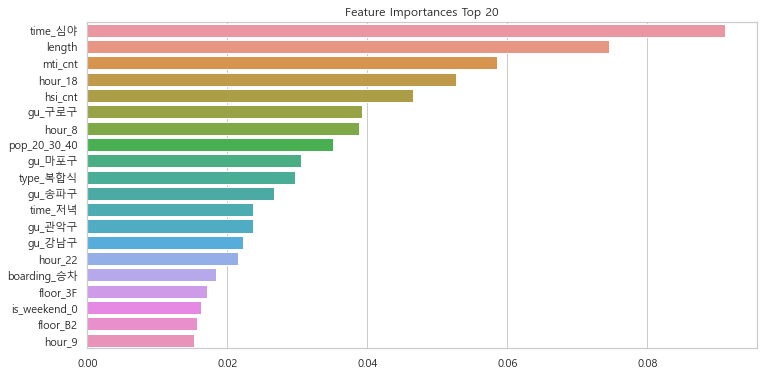

### LGBMRegressor ###


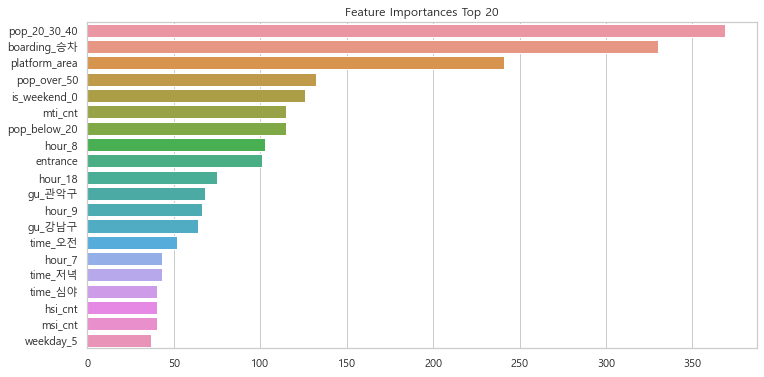

In [32]:
best_models = [xgb_bayes_opt, lgbm_bayes_opt]

for model in tqdm(best_models):
    ftr_importances(model)

- 그 결과, XGBoost 모델의 변수들 중에서 중요도가 높은 상위 5개의 변수들은 다음과 같았다.
    1. 심야 시간대(time_심야)
    2. 역사 길이(length)
    3. 역 주변 영화관 개수(mti_cnt)
    4. 18시(hour_18)
    5. 역 주변 고등학교 개수(hsi_cnt)

# 최종 결과 데이터 셋 csv 파일로 내보내기

In [33]:
new_path = 'C:/Users/Brian/Desktop/Data Science/Projects/Playdata/dataset/made_by_전처리'

In [34]:
df_test.to_csv('{}/예측 결과 시각화용_부스팅 모델.csv'.format(new_path), index = False)